Code for the simulations in the paper Fast and High-Fidelity Composite Gates in Superconducting Qubits: Beating the Fourier Leakage Limit.

The first half contains the foundational code required to simulate the system, apply the methods, and perform comparisons.

The second half provides a graphical comparison of the results achieved, along with additional infidelity plots illustrating convergence relative to system size, which are not included in the paper.

In [1]:
# Import necessary libraries
from qutip import *
from scipy.optimize import minimize
import numpy as np
import math
import matplotlib.pyplot as plt
import scqubits as scq
import scipy
from matplotlib.ticker import MaxNLocator
import scipy.optimize as optimize

In [2]:
#System size
dims = 6
# Set CP cumulative time
T = 10.
# Set transmon with 2*pi*7 GHZ qubit frequency and -0.3*2*pi GHz anharmonicity
transmon = scq.Transmon(EJ = 153.0749087439081,
                        EC = 1.7102055656790236,
                              ng = 0.,
                              ncut = 22,
                              #truncated_dim = dims      # this parameter controls the effective size of the system
                              )

energy = transmon.eigenvals(evals_count=dims)

energies = energy - energy[0]
energies = energies - energies[1]
energies[0] = 0.
sigma = T/4

In [ ]:
#Pulse shape for DRAG
def Omega_G(t):
    global sigma
    amp = np.pi

    t_g = 4*sigma
    return amp*(np.exp(-((t-t_g/2)**2)/(2*sigma**2))-np.exp(-((t_g)**2)/(8*sigma**2)))/(np.sqrt(2*np.pi*sigma**2)*math.erf(t_g/(np.sqrt(8)*sigma))-t_g*np.exp(-t_g**2/(8*sigma**2)))
# Derivative of Omega_G
def derivative_Omega_G(t):
      global sigma
      amp = np.pi
      t_g = 4*sigma
      return -((t-t_g/2))/(sigma**2)*amp*(np.exp(-((t-t_g/2)**2)/(2*sigma**2)))/(np.sqrt(2*np.pi*sigma**2)*math.erf(t_g/(np.sqrt(8)*sigma))-t_g*np.exp(-t_g**2/(8*sigma**2)))

# Control function for second DRAG term
def dragi(x,*args,**kwargs):
    global delta_2
    beta = kwargs['beta']
    eps = kwargs['e']
    chislo = float(-(1+eps)*beta*derivative_Omega_G(float(x))/(delta_2))
    return chislo

# Compute pulse area
def area(pulse,T):
    N = len(pulse)//2
    area = 0.
    for Omega in pulse[:N]:
      area += np.abs(Omega)*T/N
    return area

# Control function for first DRAG term
def drag(x,*args,**kwargs):
    
    alpha = kwargs['alpha']
    eps = kwargs['e']
    chislo = float(alpha*Omega_G(x)*(1+eps))
    return chislo

#Create Hamiltonian for a fixed Rabi Frequency
def Hamiltonian(Rabbi,phase,epsilon, n = 6, trmon = transmon,levels = False):
   if levels:
      trmon = scq.Transmon(EJ = 153.0749087439081,
                        EC = 1.7102055656790236,
                              ng = 0.,
                              ncut = 22,
                              truncated_dim = n      # this parameter control the effective size of the system
                              )
    
   q = trmon.n_operator(energy_esys=True)
   transmonia = q
   two_mons = np.zeros((2,n,n)).astype(complex)
   
   for j in range(n):
    for m in range(n):
     if j>m:
      two_mons[0,j,m] = transmonia[j,m]
     else:
      two_mons[1,j,m] = transmonia[j,m]
   eigsys = trmon.eigensys(evals_count=n)
   energies = eigsys[0] - eigsys[0][0]
   energies = energies - energies[1]
   energies[0] = 0.
   transmonche = -1/2*(1+epsilon)*Rabbi*(np.abs(two_mons[0])*np.exp(-1j*phase) + np.abs(two_mons[1])*np.exp(1j*phase))+ np.diag(energies)
   return transmonche
     

def create_gate(which,levels):          # Function to creates gates with which to compare the generated Propagator
    array = np.diag(np.ones(levels)).astype(np.complex128)
    if which == 'X':
      array[0][0] = 0.
      array[0][1] = 1.
      array[1][0] = 1.
      array[1][1] = 0.
    elif which == 'T':
        array[1][1] = np.exp(1j*np.pi/4)
    elif which == 'H':
      array[0][0] = 1/np.sqrt(2)
      array[0][1] = 1./np.sqrt(2)
      array[1][0] = 1/np.sqrt(2)
      array[1][1] = -1/np.sqrt(2)
    elif which == 'sqrtX':
      array[0][0] = 1/2*(1j+1)
      array[0][1] = 1/2*(-1j+1)
      array[1][0] = 1/2*(-1j+1)
      array[1][1] = 1/2*(1j+1)
    return array

def optimal_trace(U,G,n = 2):            # Fidelity function taken from https://arxiv.org/pdf/quant-ph/0701138.pdf equation (3)
  projector = np.zeros_like(U)
  projector[:n,:n] = np.diag(np.ones(n))

  M = np.matmul(projector,np.transpose(np.conj(G)))
  M = np.matmul(M,U)
  M = np.matmul(M,projector)
  Fidelity = 1/(n*(n+1))*(np.trace(np.matmul(M,np.transpose(np.conj(M))))+np.square(np.abs(np.trace(M))))
  return 1-Fidelity.real

# Cost function to measure fidelity and error 
def Cost_function(x,*argsa): 
    number_of_pulses = argsa[0]
    t_g = argsa[1]/number_of_pulses
    Prob = argsa[2]
    epsillon = argsa[3]
    operator = argsa[4]
    if argsa[7]:
     global solutions_EC,solutions_EJ
     anharm = solutions_EC
     EJ = solutions_EJ
    error = 0.
    if argsa[7]:
      for k in range(len(anharm)):
         Trmon1 = scq.Transmon(EJ=EJ[k],
                              EC=anharm[k],
                              ng = 0.,
                              ncut = 22,
                              )  
         U_f = np.diag(np.ones(argsa[6]).astype(np.complex128))
         for j in range(number_of_pulses):
              U_f = np.matmul(scipy.linalg.expm(-1j*t_g*Hamiltonian(x[j],x[j+len(x)//2],0., n = argsa[6],trmon=Trmon1)),U_f)
         if operator:
          error += optimal_trace(U_f,argsa[5],n = 2)
         else:
          for vam in range(2):
            error += np.abs(Prob[vam]-np.conj(U_f[vam,0])*U_f[vam,0])
    
    for eps in epsillon:
     U_f = np.diag(np.ones(argsa[6]).astype(np.complex128))
     for j in range(number_of_pulses):
           if len(argsa) == 9:
             U_f = np.matmul(scipy.linalg.expm(-1j*t_g*Hamiltonian(x[j],x[j+len(x)//2],eps, n = argsa[6],levels = True)),U_f)    
           else:   
             U_f = np.matmul(scipy.linalg.expm(-1j*t_g*Hamiltonian(x[j],x[j+len(x)//2],eps, n = argsa[6])),U_f)    
     if operator:
       error += optimal_trace(U_f,argsa[5],n = 2)
     else:
        for vam in range(2):
            if eps == 0. :
              van = 1.
            else:
              van = 1.
            error += np.abs(Prob[vam]-np.conj(U_f[vam,0])*U_f[vam,0])*van
    return error/len(epsillon)

# Function to calculate the CP infidelity for varying system sizes, based on specified parameters
def infidelity_operator(parameters,kude = [7],operatora = 'X',name = "",N = 7,T = T,prob = [0.,1.],use_operator = False):
  for na in kude:
      mia = []
      for j in range(2,21):
        operator = create_gate(operatora,j)
        if use_operator:
         plotnato = Cost_function(parameters,N,T,prob,[0.],use_operator,operator,j,False,True)
        else:
           plotnato = Cost_function(parameters,N,T,prob,[0.],use_operator,operator,j,False,True)/2
        mia.append(plotnato)    
      x = np.arange(2,len(mia)+2)
      plt.plot(x,np.array(mia),'g',label=f"n = {na}")
      
      plt.legend()
      plt.xlim(2,21)
      print(mia)
      plt.xlabel(f"$n_j$")
      plt.ylabel(r"$\mathrm{Infidelity}_{n_j}$")
      plt.yscale('log')
      plt.show()
      #plt.savefig(f"{name}.pdf")
      plt.close()

In [4]:
# Initial state for time dependent evolution
ustate = basis(dims, 0)

# DRAG Hamiltonian with control functions 
H = [Qobj(np.diag(energies)[:dims]),[Qobj(Hamiltonian(1.,0.,0.,n = dims).real),drag],[Qobj(1j*Hamiltonian(1.,0.,0.,n = dims).imag),dragi]]

# Evolution time
times = np.linspace(0,T,2)

In [5]:
import scipy.optimize
def pi_pulse_min(x):
    results_ops = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*x,0.,0, n = 6))
    return np.abs(1-np.conj(results_ops[1, 0])*results_ops[1, 0])/2+np.abs(0-np.conj(results_ops[0, 0])*results_ops[0, 0])/2

def pi_pulse_min_half(x):
    results_ops = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*x,0.,0, n = 6))
    return np.abs(0.5-np.conj(results_ops[1, 0])*results_ops[1, 0])/2+np.abs(0.5-np.conj(results_ops[0, 0])*results_ops[0, 0])/2

def pi_pulse_min_half_sqrt(x):
    results_ops = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T/2*x,0.,0, n = 6))
    return optimal_trace(results_ops, create_gate('sqrtX',6), n = 2)

#Find optimal correnctions to a single pi pulse
#Those corrections stem from the fact that we are not dealing with a simple anharmonic oscillator

res_y = minimize(pi_pulse_min,np.array([1.]))
res_y_half = minimize(pi_pulse_min_half,np.array([1.]))
res_y_half_sqrt = minimize(pi_pulse_min_half_sqrt,np.array([1.]))

print(res_y,'\n')
#print(res_y_half,'\n')
#print(res_y_half_sqrt,'\n')


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.60784900497581e-05
        x: [ 7.888e-01]
      nit: 4
      jac: [ 6.205e-07]
 hess_inv: [[ 1.261e-01]]
     nfev: 12
     njev: 6 



In [6]:
delta_2 = -0.3
# Optimal DRAG parameters for Y only correction of first order - https://arxiv.org/abs/1011.1949
def drag_optim(x,*argsi):
    result_ops = propagator(argsi[0][0], argsi[0][1],args= {'beta':x[0],'alpha':x[1],'e':0.},options = Options(nsteps=1000000)).full()
    return np.abs(1-np.conj(result_ops[1, 0])*result_ops[1, 0])/2+np.abs(0-np.conj(result_ops[0, 0])*result_ops[0, 0])/2

def drag_optim_X(x,*argsi):
    result_ops = propagator(argsi[0][0], argsi[0][1],args= {'beta':x[0],'alpha':x[1],'e':0.},options = Options(nsteps=1000000)).full()
    return optimal_trace(result_ops, create_gate('X',argsi[0][2]), n = 2)

def drag_optim_sqrtX(x,*argsi):
    result_ops = propagator(argsi[0][0], argsi[0][1],args= {'beta':x[0],'alpha':x[1],'e':0.},options = Options(nsteps=1000000)).full()
    return optimal_trace(result_ops, create_gate('sqrtX',argsi[0][2]), n = 2)

res_x = minimize(drag_optim,np.array([1.,1.]),args = [H,T])
res_x_ops = minimize(drag_optim_X,np.array([1.,1.]),args = [H,T,dims])
res_x_ops_sqrt = minimize(drag_optim_sqrtX,np.array([1.,1.]),args = [H,T,dims])

print(res_x)
#print(res_x_ops)
#print(res_x_ops_sqrt)

 C:\Users\hristo\AppData\Roaming\Python\Python311\site-packages\qutip\solver\options.py: 16

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.6665044651774585e-05
        x: [ 1.000e+00  7.889e-01]
      nit: 4
      jac: [ 0.000e+00 -6.782e-07]
 hess_inv: [[ 1.000e+00  0.000e+00]
            [ 0.000e+00  1.261e-01]]
     nfev: 18
     njev: 6


In [7]:
#Create Rabi freq. error distribution for DRAG
epsilon = np.arange(-0.2,0.21,0.001)
answer1,answer = [],[]
answer1_2,answer_2 = [],[]

for e in epsilon:

  result_ops = propagator(H, T,args= {'beta':res_x.x[0],'alpha':res_x.x[1],'e':e},options = Options(nsteps=1000000)).full()
  result_ops_x = propagator(H, T,args= {'beta':res_x_ops.x[0],'alpha':res_x_ops.x[1],'e':e},options = Options(nsteps=1000000)).full()
  
  answer.append(np.abs(0-np.conj(result_ops[0, 0])*result_ops[0, 0])/2+np.abs(1-np.conj(result_ops[1, 0])*result_ops[1, 0])/2)
  answer1.append(optimal_trace(result_ops_x, create_gate('X',6), n = 2))

  result_ops_2 = propagator(H, T,args= {'beta':res_x.x[0]/2,'alpha':res_x.x[1]/2,'e':e},options = Options(nsteps=1000000)).full()
  result_ops_2_sqrt = propagator(H, T,args= {'beta':res_x_ops_sqrt.x[0],'alpha':res_x_ops_sqrt.x[1],'e':e},options = Options(nsteps=1000000)).full()
  
  answer_2.append(np.abs(0.5-np.conj(result_ops_2[0, 0])*result_ops_2[0, 0])/2+np.abs(0.5-np.conj(result_ops_2[1, 0])*result_ops_2[1, 0])/2)
  answer1_2.append(optimal_trace(result_ops_2_sqrt, create_gate('sqrtX',6), n = 2))



In [8]:
# Find optimal EJ and EC for qubit frequency and anharmonicity
def error(params):
    EJ, EC = params
    transmon = scq.Transmon(EJ=EJ, EC=EC, ng=0, ncut=22)
    spectrum = transmon.eigenvals()
    actual_frequency = spectrum[1] - spectrum[0]  # Transition frequency between first and second levels
    actual_anharmonicity = spectrum[2] - 2 * spectrum[1] + spectrum[0]  # Anharmonicity
    return (actual_frequency - desired_frequency)**2 + (actual_anharmonicity - desired_anharmonicity)**2
solutions_EJ, solutions_EC = [],[]
initial_guess = [10.0, 0.2]

# Anharmonicty for which we will explore the robustness of the different solutions
for j in np.arange(-0.35,-0.25,0.001):
    desired_frequency = 2*np.pi*7.00  # Frequency in GHz
    desired_anharmonicity = 2*np.pi*j # Anharmonicity in GHz
    
    # Perform optimization to find the parameters that minimize the error
    result = optimize.minimize(error, initial_guess)

    # Extract the optimized parameters
    optimal_EJ, optimal_EC = result.x
    solutions_EJ.append(optimal_EJ) 
    solutions_EC.append(optimal_EC)


In [9]:
# Values for no errors in the system
print(solutions_EJ[len(solutions_EJ)//2])
print(solutions_EC[len(solutions_EC)//2])

153.074931801743
1.7102052634210765


In [10]:
#Compute DRAG values for different anharmonicities
answer2,answer3 = [],[]
answer2_sqrt,answer3_sqrtX = [],[]
for j in range(len(solutions_EC)):
  transmon = scq.Transmon(EJ = solutions_EJ[j],
                        EC = solutions_EC[j],
                              ng = 0.,
                              ncut = 22,
                              )
  dims = 6
  eigensys = transmon.eigensys(evals_count=dims)
  energy = eigensys[0]

  energies = energy - energy[0]
  energies = energies - energies[1]
  energies[0] = 0.
  
  H = [Qobj(np.diag(energies[:dims])),[Qobj(Hamiltonian(1.,0.,0.,n = 6,trmon=transmon).real),drag],[Qobj(1j*Hamiltonian(1.,0.,0.,n = 6,trmon=transmon ).imag),dragi]]
  result_ops = propagator(H, T,args= {'beta': res_x.x[0],'alpha':res_x.x[1],'e':0.},options = Options(nsteps=1000000)).full()
  answer2.append(np.abs(0-np.conj(result_ops[0, 0])*result_ops[0, 0])/2+np.abs(1-np.conj(result_ops[1, 0])*result_ops[1, 0])/2)
  answer3.append(optimal_trace(result_ops, create_gate('X',6), n = 2))
  
  H = [Qobj(np.diag(energies[:dims])),[Qobj(Hamiltonian(1.,0.,0.,n = 6,trmon=transmon).real),drag],[Qobj(1j*Hamiltonian(1.,0.,0.,n = 6,trmon=transmon ).imag),dragi]]
  result_ops_2 = propagator(H, T,args= {'beta': res_x.x[0]/2,'alpha':res_x.x[1]/2,'e': 0.},options = Options(nsteps=1000000)).full()
  result_ops_2_sqrt = propagator(H, T,args= {'beta': res_x_ops_sqrt.x[0],'alpha':res_x_ops_sqrt.x[1],'e':0.},options = Options(nsteps=1000000)).full()

  answer2_sqrt.append(np.abs(0.5-np.conj(result_ops_2[0, 0])*result_ops_2[0, 0])/2+np.abs(0.5-np.conj(result_ops_2[1, 0])*result_ops_2[1, 0])/2)
  answer3_sqrtX.append(optimal_trace(result_ops_2_sqrt, create_gate('sqrtX',6), n = 2))

 C:\Users\hristo\AppData\Roaming\Python\Python311\site-packages\qutip\solver\options.py: 16

In [11]:
# Function for plotting all cases
def plot_results(x,N = 6,T = T, operar = False,Prob = [0.,1.], ops = [],esuls = answer,name = '',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,drag_X_harm = answer3,x2 = [],pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],pi_coef_3 = res_y_half_sqrt.x[0] ,show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,drag_anharm_half = answer2_sqrt ):
    epsilon = np.arange(-0.2,0.21,0.001)
    if anharm:
          global solutions_EC,solutions_EJ
          epsilon = solutions_EC
    arr,arr_p,arr_2 = [], [], [] 
    if operar:
       opirar = create_gate(ops,dims)
    d = 0
    for eps in epsilon:
     error,error_p = 0.,0.
     error_2 = 0.
     if anharm:
         Trmon1 = scq.Transmon(EJ=solutions_EJ[d],
                              EC=eps,
                              ng = 0.,
                              ncut = 22,
                              )
         d+=1
     U_f = np.diag(np.ones(dims).astype(np.complex128))
     if len(x2) != 0:
        U_f2 = np.diag(np.ones(dims).astype(np.complex128))
     for j in range(N):
        if anharm:
           U_f = np.matmul(scipy.linalg.expm(-1j*T/N*Hamiltonian(x[j],x[j+len(x)//2],0., n = dims,trmon=Trmon1)),U_f)
           if len(x2) != 0:
             U_f2 = np.matmul(scipy.linalg.expm(-1j*T/N*Hamiltonian(x2[j],x2[j+len(x)//2],0., n = dims,trmon=Trmon1)),U_f2) 
        else:
          U_f = np.matmul(scipy.linalg.expm(-1j*T/N*Hamiltonian(x[j],x[j+len(x)//2],eps, n = dims)),U_f)
          if len(x2) != 0:
            U_f2 = np.matmul(scipy.linalg.expm(-1j*T/N*Hamiltonian(x2[j],x2[j+len(x)//2],eps, n = dims)),U_f2)

     if Prob == [0.,1.] or ops == 'X' :
        if anharm:
           U_p = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*pi_coef, 0., 0., n = dims, trmon=Trmon1))
        else:
           if operar:
              U_p = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*pi_coef,0.,eps, n = dims))
           else:
            U_p = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*pi_coef,0.,eps, n = dims))
     elif  Prob == [0.5,0.5]:
          if anharm:
           if operar:
             U_p = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*pi_coef_3/2, 0., 0., n = dims, trmon=Trmon1))
           else:
             U_p = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*pi_coef_2, 0., 0., n = dims, trmon=Trmon1))

          else:
            if operar:
              U_p = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*pi_coef_3/2,0.,eps, n = dims))
            else:
              U_p = scipy.linalg.expm(-1j*T*Hamiltonian(np.pi/T*pi_coef_2,0.,eps, n = dims))
     
     if operar:
       arr.append(optimal_trace(U_f, opirar, n = 2))
       if len(x2) != 0:
        arr_2.append(optimal_trace(U_f2, opirar, n = 2))
       if ops == 'X' or ops== 'sqrtX':
        arr_p.append(optimal_trace(U_p, opirar, n = 2))
     else:
        for vam in range(2):
            error += np.abs(Prob[vam]-np.conj(U_f[vam,0])*U_f[vam,0])/2
            if len(x2) != 0:
             error_2 += np.abs(Prob[vam]-np.conj(U_f2[vam,0])*U_f2[vam,0])/2
            error_p += np.abs(Prob[vam]-np.conj(U_p[vam, 0])*U_p[vam, 0])/2
        
        arr.append(error)  
        arr_2.append(error_2)
        arr_p.append(error_p)
    #print('Pi-pulse min',np.min(np.array(arr_p)))
    
    if not anharm:
     plt.plot(epsilon,np.array(arr),':', label = 'CP-precise',linewidth = '4.')
     if len(x2) != 0:
      plt.plot(epsilon,np.array(arr_2),'--', label = 'CP-robust',linewidth = '2.')
    else:
       #print(arr)
       plt.plot(np.arange(-0.35,-0.25,0.001),np.array(arr),':',label = 'CP-precise',linewidth = '4.')
       if len(x2) != 0:
        plt.plot(np.arange(-0.35,-0.25,0.001),np.array(arr_2),'--', label = 'CP-robust',linewidth = '2.')

       if operar:
          if ops == 'X':
           plt.plot(np.arange(-0.35,-0.25,0.001),np.array(drag_X_harm), label = 'DRAG',linewidth = '2.')
          if ops == 'sqrtX':
            plt.plot(np.arange(-0.35,-0.25,0.001),np.array(drag_sqrtX_anharm), label = 'DRAG',linewidth = '2.')
       else:
          if ops == 'X':
           plt.plot(np.arange(-0.35,-0.25,0.001),np.array(drag_harm), label = 'DRAG',linewidth = '2.')
          elif ops == 'sqrtX':
                  plt.plot(np.arange(-0.35,-0.25,0.001),np.array(drag_anharm_half), label = 'DRAG',linewidth = '2.')
    
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 16.5
    })
    
    if Prob == [0.,1.] and not anharm and not operar:
      d = 3
      plt.plot(np.arange(-0.2,0.21,0.001),np.array(esuls), label = 'DRAG',linewidth = '2.')
    elif Prob == [0.5,0.5] and not anharm and not operar:
      plt.plot(np.arange(-0.2,0.21,0.001),np.array(drag_half_eps), label = 'DRAG',linewidth = '2.')
    if operar and ops == 'X' and not anharm:
       plt.plot(np.arange(-0.2,0.21,0.001),np.array(dragni_op), label = 'DRAG')
    elif operar and ops == 'sqrtX' and not anharm:
      plt.plot(np.arange(-0.2,0.21,0.001),np.array(drag_sqrt_eps), label = 'DRAG')
    if not operar:
       if Prob == [0.,1.]:
          text = r'$\pi$-pulse'
       elif Prob == [0.5,0.5]:
          text = r'$\pi/2$-pulse'
       if not anharm:
        plt.plot(epsilon,np.array(arr_p),'r-.', label = text,linewidth = '2.')
        #print('Min location',epsilon[np.argmin(np.array(arr_p))])
       else:
          plt.plot(np.arange(-0.35,-0.25,0.001),np.array(arr_p),'r-.', label = text,linewidth = '2.')
    elif operar and not anharm:
      text = r'$\pi$-pulse'
      if Prob == [0.5,0.5]:
          text = r'$\pi/2$-pulse'
      plt.plot(epsilon,np.array(arr_p),'r-.' ,label = text,linewidth = '2.')
      #print('Min location',epsilon[np.argmin(np.array(arr_p))])
    if anharm and  ops == 'X' and operar: 
       plt.plot(np.arange(-0.35,-0.25,0.001), np.array(arr_p), label = r'$\pi$-pulse',linewidth = '2.')
    if anharm and ops == 'sqrtX' and operar:
      #d = 3
      plt.plot(np.arange(-0.35,-0.25,0.001),np.array(arr_p),'r-.', label = r'$\pi/2$-pulse',linewidth = '2.')
   # if anharm and ops == 'X':
    #  plt.plot(np.arange(-0.35,-0.25,0.001),np.array(arr_p),'r-.', label = r'$\pi$-pulse',linewidth = '2.')
    if not anharm:
     plt.xlabel(r'Rabi Frequency Deviation $\epsilon$')
    else:
       plt.xlabel(r'Anharmonicity $\delta \mathrm{[2\pi \times Ghz]}$')
    #plt.title(r'Robust $X$ gate')
    if operar:
      plt.ylabel('Infidelity')
    else:
      plt.ylabel('Error')
    
    plt.yscale('log')
    thicks = []
    for j in range(8):
     for m in range(10):
      thicks.append(m*10**-(j+2))
    
    #plt.yticks(rotation=0, fontsize=10)  # Adjust rotation and fontsize as needed
    plt.legend()
    if show:
     plt.show()
    else:
     plt.savefig(f"{name}.pdf")
    plt.close() 
    #print(np.arange(-0.2,0.21,0.001)[np.argmin(arr_2)])
    
    return arr

In [12]:
# Function that finds a precise and robust solution for a given task and system parameters.
# It then plots the results and prints the best solution
def do_everything(N,T,prob,epsi_opt,operator,iterations,anharm_e,name,ops,gate = 'sqrtX',dims = 6,bnds = []):
    resolutions,resolutions_2,cost,cost_2 = [],[],np.zeros(iterations),np.zeros(iterations)
    X = create_gate(gate,dims)
    for v in range(len(cost)):
      print(v)
      x = np.random.rand(2*N)
      x12 = np.random.rand(2*N)

      resolution = minimize(Cost_function,x,args = (N,T,prob,epsi_opt,operator,X,dims,anharm_e),bounds= bnds)
      resolution_2 = minimize(Cost_function,x12,args = (N,T,prob,[-0.07,-0.035,0.,0.035,0.07],operator,X,dims,anharm_e),bounds = bnds)
      cost[v] = Cost_function(resolution.x,N,T,prob,epsi_opt,operator,X,dims,anharm_e)
      cost_2[v] = Cost_function(resolution_2.x,N,T,prob,[-0.07,-0.035,0.,0.035,0.07],operator,X,dims,anharm_e)
      
      resolutions.append(resolution.x)
      resolutions_2.append(resolution_2.x)

    a = plot_results(resolutions[np.argmin(cost)],N = N,T = T,Prob = prob,operar = operator, ops = gate,name = f'{name}',dims = dims, x2 = resolutions_2[np.argmin(cost_2)])
    а1 = plot_results(resolutions[np.argmin(cost)],N = N,T = T, operar = operator,Prob = prob, ops = gate,name = f'{name}_anharm',anharm = True,dims = dims,x2 = resolutions_2[np.argmin(cost_2)])
    infa = infidelity_operator(resolutions[np.argmin(cost)],kude = [dims],operatora = gate,name = f"Inf_{name}",N = N,T = T,prob = prob,use_operator = operator)

    print('Precise CP - [',end='')
    for j,prec in enumerate(resolutions[np.argmin(cost)]):
     if j == len(resolutions[np.argmin(cost)]) - 1:
       print(f"{prec}",end='')
     else:
       print(f"{prec},",end='')
    print(']')
    
    print('Robust CP - [',end='')
    for j,rob in enumerate(resolutions_2[np.argmin(cost_2)]):
     if j == len(resolutions_2[np.argmin(cost_2)]) - 1:
       print(f"{rob}",end='')
     else:
       print(f"{rob},",end='')
    print(']')
    
    return resolutions,resolutions_2, cost,cost_2


In [13]:
N = 7
iterations = 1
epsi_opt = [0.]
operator = False
prob = [0.,1.]
X = create_gate('X',dims)
anharm_e = False
bnds = []
for j in range(2*N):
 if j < N:
  bnds.append((-0.62,0.62))
 else:
  bnds.append((-1.58,1.58))

#res_pop,res_pop2,cost,cost_2 = do_everything(N,T,prob,epsi_opt,operator,iterations,anharm_e,'moi_pop_opit_malko',[],dims = 6,gate = 'X',bnds = bnds)
#res_pop_half,res_pop2_half,cost_half,cost_2half = do_everything(N,T,[0.5,0.5],epsi_opt,operator,iterations,anharm_e,'moi_pop_opit_half',[],dims = 6,gate = 'sqrtX',bnds = bnds)

#res_X_opit,res_X2_opit,costX_opit,cost_X2_opit = do_everything(N,T,prob,epsi_opt,True,iterations,anharm_e,'moi_X',[],dims = 6,gate = 'X',bnds = bnds)
#res_sqrtX_opit,res_sqrt2X_opit,cost_sqrtX_opit,cost_sqrt2X_opit = do_everything(N,T,[0.5,0.5],epsi_opt,True,iterations,anharm_e,'moi_sqrtX',[],dims = 6,gate = 'sqrtX',bnds = bnds)



In [14]:
pop_trans_precise =  [0.1878151245707219,0.1354743195431266,0.23261775185977634,0.3304218227215762,0.3553431653483842,0.32589559721925343,0.19784308013340995,0.8776067612255902,0.862679617024402,0.38981227432247273,0.38926591527320314,0.7198168822582821,0.6368128062835569,0.6009480156501823]
pop_trans_robust = [0.62,0.62,-0.6194916207543971,0.6197862425722596,0.28606770231356804,0.606747185429687,0.14342514005160503,0.4390048579763593,-0.2377529484998005,1.58,-1.2425600564754922,0.36227544885085755,0.2831143743942778,0.36179689026502176]

half_pop_previse = [0.24782851941760753,0.2761947625451705,0.3985427285339283,0.4398,0.4397988468229309,0.4398,0.38674350625477866,0.5799555317761592,0.43093719871049785,0.29909218607997884,0.1458071567544756,0.42452756101595673,0.1537203690446601,0.32950796165814966]
half_pop_robust = [-0.34073115729167175,0.6197338433549028,0.3546250637219452,0.6165181770088474,-0.260620066989484,0.29341621324773226,0.5538658697864219,0.7330036978578892,-0.17721589496008847,0.05656274382379691,-0.40421663371745437,0.6722374767233017,0.6720510608715242,1.58]

X_gate_precie = [0.07139295587823936,0.23067186128488268,0.28779263744922523,0.3160105301414442,0.3952221818410018,0.3279961144115221,0.13235525159790845,0.14245347349484488,0.18845345280572345,0.16939774063878538,-0.14360881937701667,-0.08776480673945283,0.13250455673909128,0.3472135303081338]
X_gate_robust = [0.6156,0.6156,0.6156,0.6156,0.6156,0.6156,0.6156,-0.4681862291646809,1.1784075786820956,0.957687770472053,-0.7631558658691192,-1.4414502627765007,0.14939041797708655,1.5001977098243318]

sqrtX_gate_precise = [0.26751171355478864,0.4398,0.43606629989336626,0.4398,0.4306465412632002,0.4398,0.23719812366102638,-0.12681854543566184,0.31227287238722273,0.21186606805079666,0.03754676725409053,-0.05451227058736811,0.10489243281382894,0.7319070657505853]
sqrtX_gate_robust = [0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.9442063037293843,-0.1081628717619899,-1.150052869038299,1.4643293615531379e-05,1.1514306083718713,0.10832413675369186,-0.9453395680145497]

In [15]:
# Convert Rabi to 2pi MHz and phase in pi units 
print('Precise CP - [',end='')
for j,prec in enumerate(np.array(sqrtX_gate_precise)):
    if j< 7:
      print(f"{(prec / 2 / np.pi * 1000).round(3)},",end='')
    else:
      print(f"{(prec / np.pi).round(4)},",end='')
print(']')

Precise CP - [42.576,69.996,69.402,69.996,68.54,69.996,37.751,-0.0404,0.0994,0.0674,0.012,-0.0174,0.0334,0.233,]


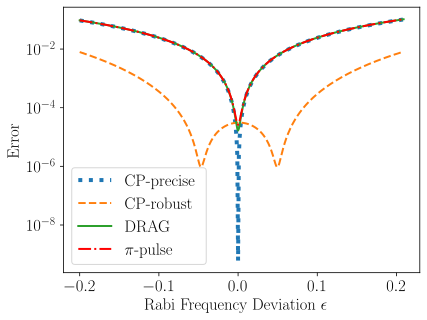

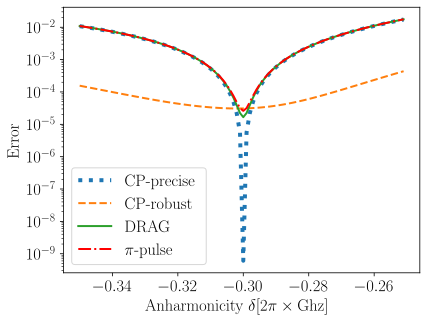

In [16]:
# Plot and save the results for population transfer
a = plot_results(pop_trans_precise,N = 7,T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans_dulgo',dims = 6, x2 = pop_trans_robust,anharm= False,show = False)
a = plot_results(pop_trans_precise,N = 7,T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans_dulgo',dims = 6, x2 = pop_trans_robust,anharm= False,show = True)

a = plot_results(pop_trans_precise,N = 7,T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans_anharm_dulgo',dims = 6, x2 = pop_trans_robust,anharm= True,show = True)
a = plot_results(pop_trans_precise,N = 7,T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans_anharm_dulgo',dims = 6, x2 = pop_trans_robust,anharm= True,show = False)


[1.9910399251421902e-05, 4.024289629726823e-10, 4.886814898911562e-10, 6.171723940776416e-10, 6.083243382518062e-10, 6.08776178177579e-10, 6.086918052651479e-10, 6.087446215947524e-10, 6.087320761597344e-10, 6.087573398578388e-10, 6.087628354580855e-10, 6.087526214888595e-10, 6.087392987638119e-10, 6.087387436535328e-10, 6.087387436535168e-10, 6.087387436535088e-10, 6.087386326312617e-10, 6.087387991638852e-10, 6.087768243683389e-10]


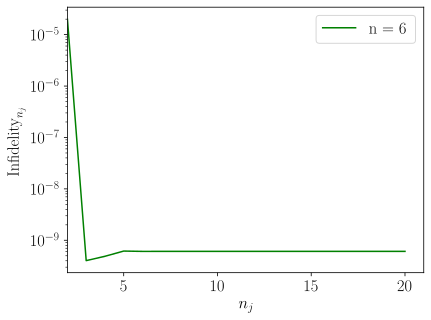

In [17]:
a = infidelity_operator(pop_trans_precise,kude = [6],operatora = 'X',name = "infid_pop",N = 7,T = T,prob = [0.,1.],use_operator = False)

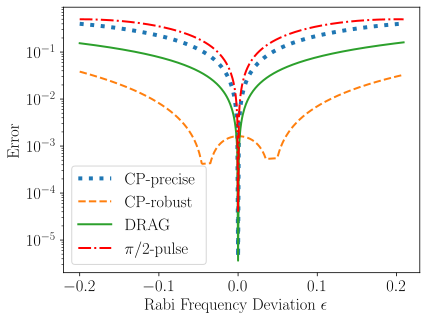

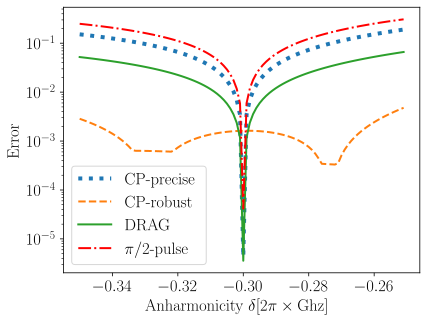

In [18]:
a = plot_results(half_pop_previse,N = 7,T = T,Prob = [0.5,0.5],operar = False, ops = 'sqrtX',name = f'half_pop_trans',dims = 6, x2 = half_pop_robust,anharm= False,show = False)
a = plot_results(half_pop_previse,N = 7,T = T,Prob = [0.5,0.5],operar = False, ops = 'sqrtX',name = f'half_pop_trans',dims = 6, x2 = half_pop_robust,anharm= False,show = True)

a = plot_results(half_pop_previse,N = 7,T = T,Prob = [0.5,0.5],operar = False, ops = 'sqrtX',name = f'half_pop_trans_anharm',dims = 6, x2 = half_pop_robust,anharm= True,show = False)
a = plot_results(half_pop_previse,N = 7,T = T,Prob = [0.5,0.5],operar = False, ops = 'sqrtX',name = f'half_pop_trans_anharm',dims = 6, x2 = half_pop_robust,anharm= True,show = True)

[0.0009368945345502033, 4.0720916136272045e-06, 4.341029250398698e-06, 4.345243674458432e-06, 4.345415164863642e-06, 4.345415622303284e-06, 4.345416997397766e-06, 4.345417300960497e-06, 4.345417328938117e-06, 4.345417311174549e-06, 4.345417309314925e-06, 4.345417343731839e-06, 4.345417416035113e-06, 4.345417416923292e-06, 4.3454174170065585e-06, 4.345417416784514e-06, 4.345417416784514e-06, 4.345417416146136e-06, 4.345417409429286e-06]


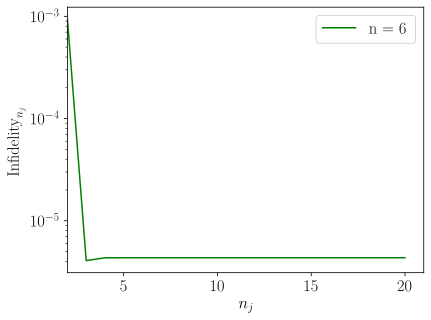

In [19]:
a = infidelity_operator(half_pop_previse,kude = [6],operatora = 'sqrtX',name = "infid_half_pop",N = 7,T = T,prob = [0.5,0.5],use_operator = False)

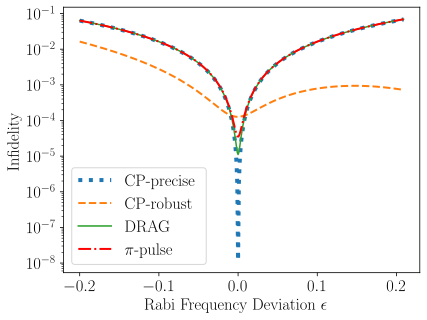

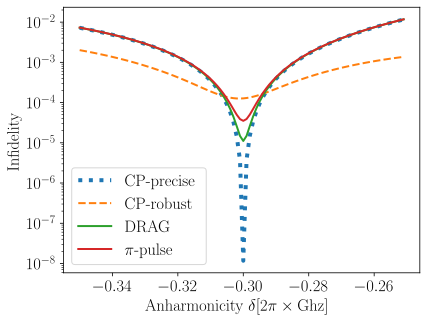

In [20]:
a = plot_results(X_gate_precie,N = 7,T = T,Prob = [0.,1.],operar = True, ops = 'X',name = f'X_gate',dims = 6, x2 = X_gate_robust,anharm= False,show = True)
a = plot_results(X_gate_precie,N = 7,T = T,Prob = [0.,1.],operar = True, ops = 'X',name = f'X_gate',dims = 6, x2 = X_gate_robust,anharm= False,show = False)

a = plot_results(X_gate_precie,N = 7,T = T,Prob = [0.,1.],operar = True, ops = 'X',name = f'X_gate_anharm',dims = 6, x2 = X_gate_robust,anharm= True,show = True)
a = plot_results(X_gate_precie,N = 7,T = T,Prob = [0.,1.],operar = True, ops = 'X',name = f'X_gate_anharm',dims = 6, x2 = X_gate_robust,anharm= True,show = False)


[1.564519680807841e-05, 2.3222246348097997e-09, 2.8633952986467648e-09, 1.1675784672426914e-08, 1.170251218152174e-08, 1.1702196767160444e-08, 1.1702350977138565e-08, 1.1702365076970977e-08, 1.1702381508271742e-08, 1.1702430358084825e-08, 1.1702434354887714e-08, 1.1702421920389838e-08, 1.1702464552953984e-08, 1.17024923085296e-08, 1.17024923085296e-08, 1.17024923085296e-08, 1.1702492974663414e-08, 1.17024923085296e-08, 1.1702578239791706e-08]


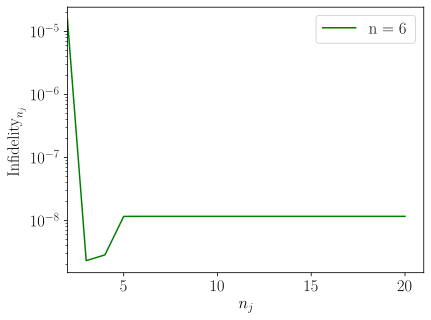

In [21]:
a = infidelity_operator(X_gate_precie,kude = [6],operatora = 'X',name = "infid_X",N = 7,T = T,prob = [0.,1.],use_operator = True)

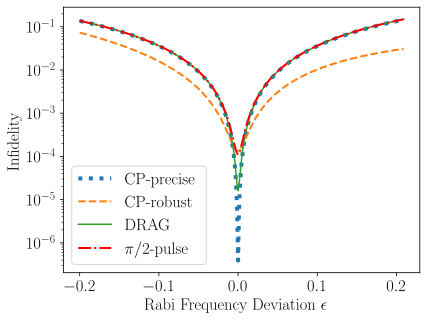

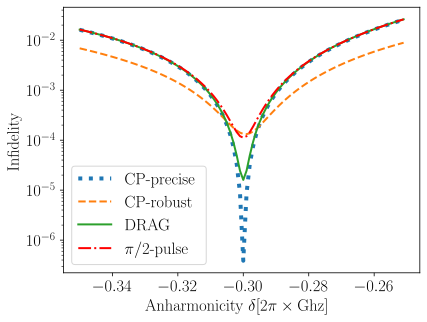

In [22]:
a = plot_results(sqrtX_gate_precise,N = 7,T = T,Prob = [0.5,0.5],operar = True, ops = 'sqrtX',name = f'sqrtX_gate',dims = 6, x2 = sqrtX_gate_robust,anharm= False,show = True)
a = plot_results(sqrtX_gate_precise,N = 7,T = T,Prob = [0.5,0.5],operar = True, ops = 'sqrtX',name = f'sqrtX_gate',dims = 6, x2 = sqrtX_gate_robust,anharm= False,show = False)

a = plot_results(sqrtX_gate_precise,N = 7,T = T,Prob = [0.5,0.5],operar = True, ops = 'sqrtX',name = f'sqrtX_gate_anharm',dims = 6, x2 = sqrtX_gate_robust,anharm= True,show = False)
a = plot_results(sqrtX_gate_precise,N = 7,T = T,Prob = [0.5,0.5],operar = True, ops = 'sqrtX',name = f'sqrtX_gate_anharm',dims = 6, x2 = sqrtX_gate_robust,anharm= True,show = True)


[1.6264912464758474e-05, 4.5843973894843515e-07, 3.6502780331737483e-07, 3.8883266095801616e-07, 3.880188630400738e-07, 3.880204582085156e-07, 3.8801683532874165e-07, 3.8801701185420256e-07, 3.880169507919362e-07, 3.880169721082183e-07, 3.8801696156109955e-07, 3.880169469061556e-07, 3.8801690283030155e-07, 3.8801693091894407e-07, 3.88016932362234e-07, 3.880169314740556e-07, 3.880169328063232e-07, 3.880169322512117e-07, 3.880169046066584e-07]


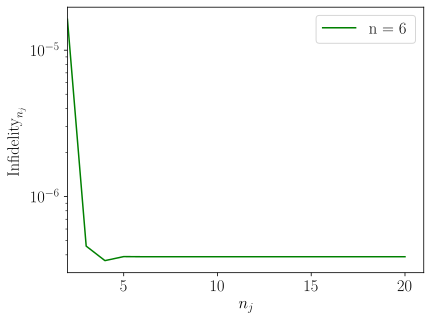

In [23]:
a = infidelity_operator(sqrtX_gate_precise,kude = [6],operatora = 'sqrtX',name = "infid_sqrtX",N = 7,T = T,prob = [0.5,0.5],use_operator = True)